# Evaluate a UQ model

In [1]:
print("apple")

apple


In [2]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.drop_UNet import UNet

# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.tversky_loss import TverskyLoss
from trustworthai.utils.losses_and_metrics.misc_metrics import IOU
from trustworthai.utils.losses_and_metrics.dice import dice, DiceMetric
from trustworthai.utils.losses_and_metrics.dice_losses import DiceLoss, GeneralizedDiceLoss
from trustworthai.utils.losses_and_metrics.power_jaccard_loss import PowerJaccardLoss
from torch.nn import BCELoss, MSELoss

# pl
from trustworthai.utils.uq.sampling.sampling_pl_wrapper import UQSamplingPredictorLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary

In [3]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

In [5]:
# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ]
# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ] + [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]

domains = [
            ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
          ]

In [6]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop, seed):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    return train, val, test

In [7]:
is3D = False

In [8]:
# augmentation definintion
def get_transforms(is3D):
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        # RandomAffine(p=0.2, shear=(.1,3.)),
        # RandomAffine(p=0.2, degrees=5),
        # RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
    ]
    if not is3D:
        return PairedCompose(transforms)
    else:
        transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
        return PairedCompose(transforms)

In [9]:
if is3D:
    transforms = CropZDim(size=32, minimum=0, maximum=-1)
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is3D)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is3D)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [10]:
len(train_dataset), len(val_dataset), len(test_dataset)

(8743, 2497, 1248)

In [11]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

### Evaluate each model in turn

In [18]:
from trustworthai.utils.uq.sampling.uq_prediction_sampler import ModeUQSampler, UQSampler

In [12]:
#from trustworthai.utils.uq.sampling.sampling_pl_wrapper import UQSamplingPredictorLitModelWrapper
from trustworthai.utils.uq.uncertainty_maps.gen_map import samples_entropy_map, samples_variance_map
from trustworthai.utils.uq.sampling.uq_prediction_sampler import DeterministicModelUQSampler, DeterministicModelNoSample
from natsort import natsorted

In [13]:
import os
from collections import namedtuple

In [14]:
root_checkpoint_dir = "/home/s2208943/ipdis/results/dropout_and_norm_initial_tests/"

def gen_folder_name(args, checkpoint_dir):
    # NOTE IF THE ARGS WERE INPUT WOULD NEED THE EXTRACT BOOL FUNCTOIN
    use_multidim_dropout = args.use_multidim_dropout
    use_multidim_dropconnect = args.use_multidim_dropconnect
    #print(use_multidim_dropconnect)
    
    # calculate the checkpoint folder name
    dropout_str = f"dropout_{args.dropout_type}_{args.dropout_p}_" if args.dropout_type != None else ""
    
    a = use_multidim_dropout
    b = (args.dropout_type != None)
    
    if (use_multidim_dropout and (args.dropout_type != None)):
        dropout_str = f"{dropout_str}mdim_"
    
    dropconn_str = f"dropconn_{args.dropconnect_type}_{args.dropconnect_p}_" if args.dropconnect_type != None else ""
    if use_multidim_dropconnect and args.dropconnect_type != None:
        dropconn_str = f"{dropconn_str}mdim_"
    
    norm_str = args.norm_type
    epochs_str = f"epochs_{args.max_epochs}"
    
    checkpoint_dir = os.path.join(checkpoint_dir, f"UNet2D_{dropout_str}{dropconn_str}{norm_str}_{epochs_str}")
    #print("checkpoint_dir: ", checkpoint_dir)
    
    return checkpoint_dir, args

def gen_args(dropout_type, drop_connect_type, p, norm_type, mdim, mepochs):
    fields = {
        "dropout_type":dropout_type,
        "dropconnect_type":drop_connect_type,
        "dropout_p":p,
        "dropconnect_p":p,
        "p":p,
        "mdim":mdim,
        "use_multidim_dropout":mdim,
        "use_multidim_dropconnect":mdim,
        "norm_type":norm_type,
        "max_epochs":mepochs
    }
    return namedtuple("args", fields.keys())(*fields.values())

In [15]:
folders = []
ps = [0.05, 0.1, 0.2, 0.3, 0.4]
multidim = [True, False]
    
for p in ps:
    for mdim in multidim:
        folders.append(gen_folder_name(gen_args(None, "bernoulli", p, 'bn', mdim, 400),root_checkpoint_dir))
        folders.append(gen_folder_name(gen_args(None, "gaussian", p, 'bn', mdim, 400),root_checkpoint_dir))
        folders.append(gen_folder_name(gen_args("bernoulli", None, p, 'bn', mdim, 400),root_checkpoint_dir))
        folders.append(gen_folder_name(gen_args("gaussian", None, p, 'bn', mdim, 400),root_checkpoint_dir))
        folders.append(gen_folder_name(gen_args("bernoulli", "gaussian", p, 'bn', mdim, 400),root_checkpoint_dir))
        folders.append(gen_folder_name(gen_args("gaussian", "bernoulli", p, 'bn', mdim, 400),root_checkpoint_dir))
folders.append(gen_folder_name(gen_args(None, None, None, 'bn', True, 400),root_checkpoint_dir))
folders.append(gen_folder_name(gen_args(None, None, None, 'in', True, 400),root_checkpoint_dir))
folders.append(gen_folder_name(gen_args(None, None, None, 'gn', True, 400),root_checkpoint_dir))


In [16]:
accelerator="gpu"
devices=1
precision = 16

trainer = pl.Trainer(
    accelerator=accelerator,
    devices=devices,
    precision=precision,
)

Using 16bit native Automatic Mixed Precision (AMP)
/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
in_channels = 3
out_channels = 1
# TODO: put in the path to the assets on your machine here
"UNet2D_dropout_bernoulli_0.4_bn_epochs_400/"

loss = GeneralizedDiceLoss(normalization='sigmoid')

# results = []

# for folder, args in folders:
#     model = UNet(in_channels,
#                  out_channels,
#                  kernel_size=3,
#                  init_features=32,
#                  softmax=False,
#                  dropout_type=args.dropout_type,
#                  dropout_p=args.p,
#                  gaussout_mean=1, 
#                  dropconnect_type=args.dropconnect_type,
#                  dropconnect_p=args.p,
#                  gaussconnect_mean=1,
#                  norm_type=args.norm_type,
#                  use_multidim_dropout=args.mdim,  
#                  use_multidim_dropconnect=args.mdim, 
#                  groups=None,
#                  gn_groups=4, 
#                 )
#     files = natsorted(os.listdir(folder))
#     epochs = [f for f in files if "epoch" in f]
#     checkpoint = os.path.join(folder, epochs[-1]) # last saved one should be best epoch...
#     print(checkpoint)

#     sampler = DeterministicModelNoSample(N=20, is_uq_model=True)
#     model = UQSamplingPredictorLitModelWrapper.load_from_checkpoint(checkpoint, model=model, loss=loss, sampler=sampler, is_uq_model=True)
    
#     r = trainer.validate(model, val_dataloader)
#     results.append((r, folder))

In [17]:
#[(r[0]['val_loss'], f.split("/")[-1]) for (r, f) in results]

In [19]:
# mode_results = []

# nonorm_loss = GeneralizedDiceLoss(normalization='none')

# for folder, args in folders:
#     model = UNet(in_channels,
#                  out_channels,
#                  kernel_size=3,
#                  init_features=32,
#                  softmax=False,
#                  dropout_type=args.dropout_type,
#                  dropout_p=args.p,
#                  gaussout_mean=1, 
#                  dropconnect_type=args.dropconnect_type,
#                  dropconnect_p=args.p,
#                  gaussconnect_mean=1,
#                  norm_type=args.norm_type,
#                  use_multidim_dropout=args.mdim,  
#                  use_multidim_dropconnect=args.mdim, 
#                  groups=None,
#                  gn_groups=4, 
#                 )
#     files = natsorted(os.listdir(folder))
#     epochs = [f for f in files if "epoch" in f]
#     checkpoint = os.path.join(folder, epochs[-1]) # last saved one should be best epoch...
#     print(checkpoint)

#     sampler = ModeUQSampler(N=20, is_uq_model=True, apply_binning=True, norm_function=torch.sigmoid)
#     model = UQSamplingPredictorLitModelWrapper.load_from_checkpoint(checkpoint, model=model, loss=nonorm_loss, sampler=sampler, is_uq_model=True)
    
#     r = trainer.validate(model, val_dataloader)
#     mode_results.append((r, folder))

In [20]:
#[(rm[0][0]['val_loss'] < r[0][0]['val_loss']) for (rm, r) in zip(mode_results, results)]
#[(r[0]['val_loss'], f.split("/")[-1]) for (r, f) in mode_results]

In [23]:
# write each thing to the file
def write_results_list(rlist, name):
    with open(name + ".txt", 'w') as file:
        for (r, f) in rlist:
            file.write(str(r[0]['val_loss']))
            file.write(":")
            file.write(f)
            file.write("\n")

In [61]:
# write_results_list(results, "results_tables/deterministic_uq_paramtest")
# write_results_list(mode_results, "results_tables/mode_uq_paramtest")

In [52]:
class ModeUQSampler(UQSampler):
    """
    this is what we should use for semantic segmentation
    https://arxiv.org/pdf/1807.07356.pdf (Section 3)
    """
    def __init__(self, apply_thresholding=False, threshold=0.7, apply_binning=False, bin_decimal=1, norm_function=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.apply_thresholding = apply_thresholding
        self.threshold = threshold
        self.apply_binning = apply_binning
        self.bin_decimal = bin_decimal
        self.norm_func = norm_function
        
        if apply_thresholding and apply_binning:
            raise ValueError("can only do one of thresholding or binning, not both")
    
    def _gen_mle_estimate(self, x, samples, model, **kwargs):
        if self.apply_thresholding:
            samples = samples > self.threshold
        if self.apply_binning:
            samples = torch.round(samples, decimals=self.bin_decimal)
            
        if self.norm_func:
            samples = self.norm_func(samples)

        #print(samples.shape)
        mode = torch.mode(samples, dim=1)[0]
        #print(mode.shape)
        return mode

### now picking a specific model

dropout 0.3: 

/home/s2208943/ipdis/results/dropout_and_norm_initial_tests/UNet2D_dropout_bernoulli_0.3_mdim_bn_epochs_400

dropconnect 0.3: 

home/s2208943/ipdis/results/dropout_and_norm_initial_tests/UNet2D_dropconn_gaussian_0.3_mdim_bn_epochs_400

spike and slab 0.3: 

'slab and spike' 0.3:


bn:

/home/s2208943/ipdis/results/dropout_and_norm_initial_tests/UNet2D_bn_epochs_400

in:

/home/s2208943/ipdis/results/dropout_and_norm_initial_tests/UNet2D_in_epochs_400

I also need to test mdim vs not mdim

In [53]:
def get_last_checkpoint(folder):
    files = natsorted(os.listdir(folder))
    epochs = [f for f in files if "epoch" in f]
    checkpoint = os.path.join(folder, epochs[-1])
    return checkpoint

def get_folder_args(folder):
    for (f, a) in folders:
        if f == folder:
            return a

In [149]:
root_folder = "/home/s2208943/ipdis/results/dropout_and_norm_initial_tests/"
exp_folder = root_folder + "UNet2D_dropout_bernoulli_0.3_mdim_bn_epochs_400"
#exp_folder = root_folder + "UNet2D_in_epochs_400"

chkpt = get_last_checkpoint(exp_folder)

args = get_folder_args(exp_folder)

In [150]:
loss = GeneralizedDiceLoss(normalization='none')

model = UNet(in_channels,
             out_channels,
             kernel_size=3,
             init_features=32,
             softmax=False,
             dropout_type=args.dropout_type,
             dropout_p=args.p,
             gaussout_mean=1, 
             dropconnect_type=args.dropconnect_type,
             dropconnect_p=args.p,
             gaussconnect_mean=1,
             norm_type=args.norm_type,
             use_multidim_dropout=args.mdim,  
             use_multidim_dropconnect=args.mdim, 
             groups=None,
             gn_groups=4, 
            )

In [151]:
sampler = ModeUQSampler(N=20, is_uq_model=True, norm_function=torch.sigmoid)
model = UQSamplingPredictorLitModelWrapper.load_from_checkpoint(chkpt, model=model, loss=loss, sampler=sampler, is_uq_model=True)

In [250]:
trainer.validate(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.2748901844024658
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.2748901844024658}]

In [153]:
# check this is actually true still!!
model.model.applyfunc

True

### Implementing Calibration

one method is to use volume variation coefficient
VVC = sigma_v / mean_v, this is calculated across all the samples.

three other ways, see
- how they did it in the spike and slab paper
- how the do it in the ieee paper
- how they do it in the batch norm paper.


other plots

the https://arxiv.org/pdf/1807.07356.pdf paper also has error rate vs
uncertainty plots (a bit like those batch norm plots)
and I think these would be good to implement.

Also I need to implement the overlap uncertainty on prediction plots and put all of these functions in the plots script.

Then move on to the other reporductoin parts, try calibration on unseen data (test set and other domains) and try adversarial stuff, move on to the ssn paper.

In [251]:
results = trainer.predict(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [409]:
# we do the [:-1] on results to drop the last batch which is of length 1
samples = torch.stack([r[0] for r in results[:-1]], dim=1).type(torch.float32)
mle_ests = torch.stack([r[1] for r in results[:-1]], dim=1)
xs = torch.stack([r[2] for r in results[:-1]], dim=1)
ys = torch.stack([r[3] for r in results[:-1]], dim=1)

In [410]:
samples.shape

torch.Size([16, 77, 20, 1, 224, 160])

In [411]:
batch = 0
b1_sample = samples[batch]
b1_mle_est = mle_ests[batch]
b1_xs = xs[batch]
b1_ys = ys[batch]

In [412]:
b1_tsample = b1_sample.type(torch.float32)

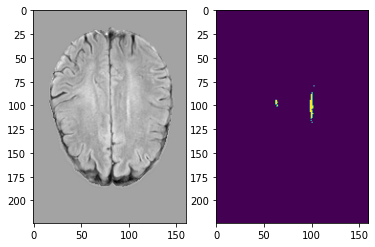

In [413]:
img = 55
plt.subplot(1,2,1)
plt.imshow(b1_xs[img][0].squeeze(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(b1_ys[img].squeeze()); plt.show()

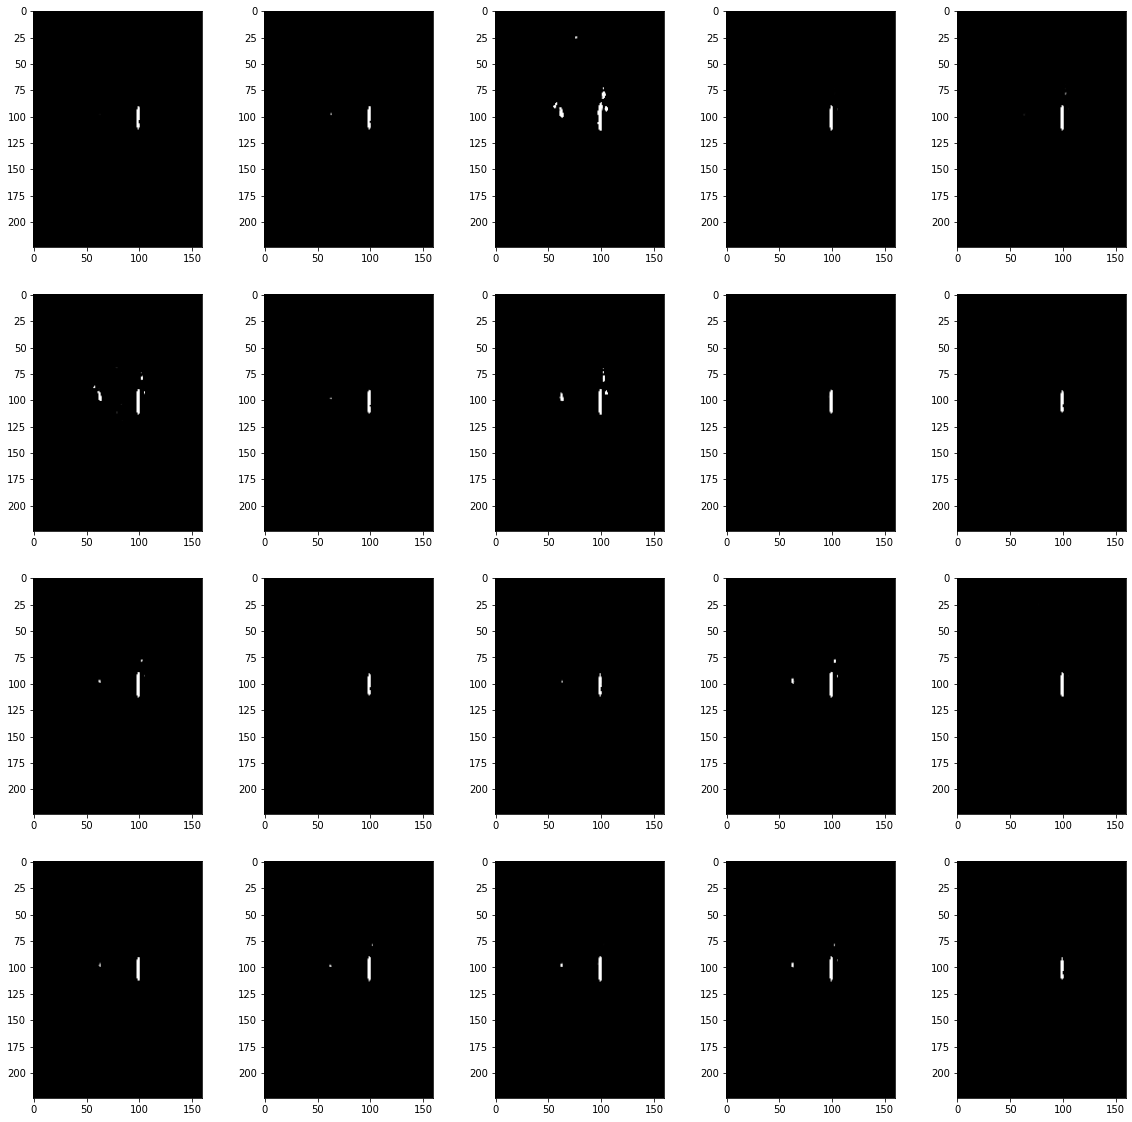

In [414]:
# see all the samples from an index in the batch
# this is messed up it should be 77, 16 not 16, 77
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(torch.sigmoid(b1_tsample[img, i]).squeeze(), cmap='gray')

In [415]:
# plt.figure(figsize=(20, 20))
# for i in range(20):
#     plt.subplot(4, 5, i+1)
#     plt.imshow((b1_tsample[img, i]).squeeze(), cmap='gray')

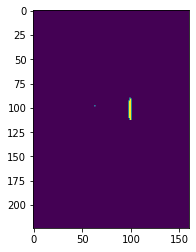

In [416]:
plt.imshow(b1_mle_est[img].squeeze()); plt.show()

In [417]:
# loss of a sample
loss(b1_mle_est[img] > 0.5, b1_ys[img]), dice(b1_mle_est[img] > 0.5, b1_ys[img])

(tensor(0.3931), tensor(0.7733))

In [418]:
e = samples_entropy_map(torch.sigmoid(b1_tsample[img].type(torch.float32)),
                    p_from_mode=True,
                    threshold_preds=False,
                    preds_threshold=None,
                    apply_norm=False,
                    norm_func='sigmoid',
                    apply_binning=True,
                    binning_dp = 1,
                    supress_warning=False,
                    print_uniques=True
                   )

warning, binning should only be applied where output is a probability
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


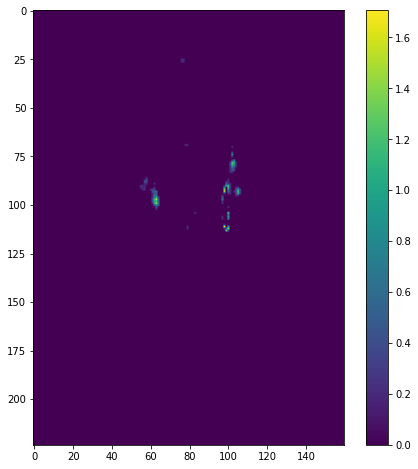

In [419]:
plt.figure(figsize=(8,8))
plt.imshow(e.squeeze())
plt.colorbar()
plt.show()


In [420]:
e2 = samples_entropy_map(torch.sigmoid(b1_tsample[img].type(torch.float32)),
                    p_from_mode=True,
                    threshold_preds=True,
                    preds_threshold=0.5,
                    apply_norm=False,
                    norm_func='sigmoid',
                    apply_binning=False,
                    binning_dp = 1,
                    supress_warning=False,
                    print_uniques=True
                   )

warning, thresholding only valid for binary class problem
[False  True]


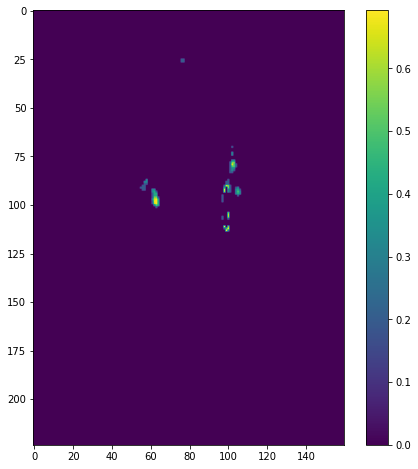

In [421]:
plt.figure(figsize=(8,8))
plt.imshow(e2.squeeze())
plt.colorbar()
plt.show()


### Implementing dice vs uncertainty plot

In [422]:
mle_ests.shape

torch.Size([16, 77, 1, 224, 160])

In [423]:
ys.shape

torch.Size([16, 77, 1, 224, 160])

In [436]:
# first a plot of dices
dices = [dice(mle_ests[b, bi] > 0.5, ys[b, bi]) 
         for b in range(ys.shape[0])
         for bi in range(ys.shape[1])
]

In [425]:
dices_sorted = torch.sort(torch.Tensor(dices))[0]

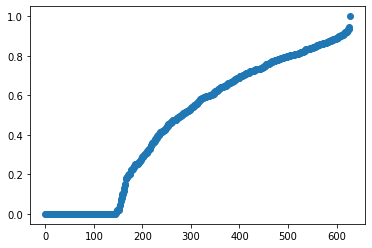

In [426]:
plt.scatter(np.arange(0, len(dices), 1), dices_sorted); plt.show()

In [435]:
# now a plot of the VCC score

def calc_VCC(sample_set, norm=True):
    if norm:
        sample_set = torch.sigmoid(sample_set)
    return torch.std(sample_set) / torch.mean(sample_set)

# first a plot of dices
VCC_norm = [calc_VCC(samples[b, bi], norm=True) 
         for b in range(ys.shape[0])
         for bi in range(ys.shape[1])
]

VCC = [calc_VCC(samples[b, bi], norm=False) 
         for b in range(ys.shape[0])
         for bi in range(ys.shape[1])
]

In [446]:
torch.isnan(dices[0])

tensor(True)

In [453]:
pairs = np.array([(d, v) for (d, v) in zip(dices, VCC_norm) if not torch.isnan(d) and v < 100])

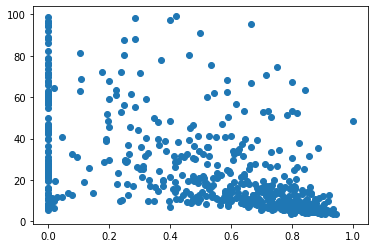

In [454]:
plt.scatter(pairs[:,0], pairs[:,1]); plt.show()

In [472]:
dices[0:10]

[tensor(nan),
 tensor(0.2857),
 tensor(0.),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(0.4667),
 tensor(nan),
 tensor(0.8400),
 tensor(nan)]

In [460]:
[d for d in dices if not torch.isnan(d)][0:5]

[tensor(0.2857), tensor(0.), tensor(0.4667), tensor(0.8400), tensor(0.3857)]

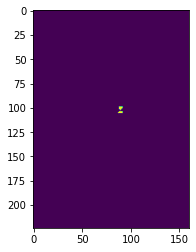

In [473]:
plt.imshow(ys[0][2].squeeze()); plt.show()

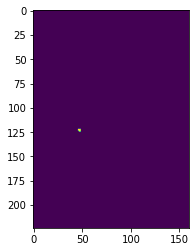

In [474]:
plt.imshow(mle_ests[0][2].squeeze()); plt.show()

In [469]:
dice(mle_ests[0][1].squeeze() > 0.5, ys[0][1].squeeze())

tensor(0.2857)

In [432]:
calc_VCC(samples[0][0])

tensor(22.2869)

In [396]:
torch.std(samples[0][0])

tensor(6.2617, dtype=torch.float16)

In [408]:
torch.mean(samples[0][0].squeeze().type(torch.float32))

tensor(-23.7738)

In [407]:
torch.mean(samples[0][0].type(torch.float32))

tensor(-23.7738)

In [475]:
batch_samples = torch.stack([r[0] for r in results[:-1]], dim=0).type(torch.float32)

In [476]:
batch_samples.shape

torch.Size([77, 16, 20, 1, 224, 160])

In [477]:
batch_mle_ests = torch.stack([r[1] for r in results[:-1]], dim=0).type(torch.float32)

In [482]:
batch_ys = torch.stack([r[3] for r in results[:-1]], dim=0).type(torch.float32)

In [483]:
batch_ys.shape

torch.Size([77, 16, 1, 224, 160])

In [500]:
# for i in range(77):
#     print(1 - loss(batch_mle_ests[i], batch_ys[i]))
#     print(dice(batch_mle_ests[i] > 0.5, batch_ys[i]))
    
#     ds = []
#     for j in range(16):
#       ds.append(dice(batch_mle_ests[i][j], batch_ys[i][j]))
#     print(torch.mean(torch.tensor([d for d in ds if not torch.isnan(d)])))
          
#     print()

### try loading the data in 3D

### Calibrate some models

In [379]:
torch.std

<function _VariableFunctionsClass.std>